In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from joblib import parallel_backend
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import FeatureHasher
from csv import writer

# NOTE change your file path
master_df = pd.read_csv(r"C:\Users\Bram\gitrepo\CS6140-final-project\raw\Flights_2018_1.csv",
                nrows=10000,
                low_memory=False # TODO not sure what this does
                )

# NOTE ***** SET THE NUMBER OF CORES FOR YOUR COMPUTER HERE*****#
NUM_CORES = 16
#***************************************************************#

In [ ]:
def analyze_model(model, X_test, X_train, y_test, y_train):
    # TODO score vs score_samples
    test_accuracy = model.score(X_test, y_test)
    train_accuracy = model.score(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    prf = precision_recall_fscore_support(y_test, y_pred, average='binary') # TODO different average values: micro macro binary weighted samples

    print(f"Test accuracy: {test_accuracy}")
    print(f"Train accuracy: {train_accuracy}")
    print(f"Precision: {prf[0]}")
    print(f"Recall: {prf[1]}")
    print(f"F-Beta Score: {prf[2]}")
    print(f"F1 Score: {f1}")

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()

In [ ]:
'''
process data for training, split into test and train
'''
feature_cols = ["DayofMonth","Month","Year", "Distance","DepDelay", "ArrDel15", "Operating_Airline "]
df = master_df[feature_cols].dropna() # get rid of nan

# NOTE remove operating airline if not using one hot encoding
X = df[["DayofMonth","Month","Year", "Distance", "DepDelay", "Operating_Airline "]]
y = df[["ArrDel15"]]
y = y.ArrDel15.ravel() # flatten

print("# samples after dropping nan:", y.shape[0])

# split into train and 
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=150) # TODO how to choose random state


In [ ]:
'''
NOTE Uncomment this cell to try Feature Hasher
You'll have to add it to the pipeline
'''
# fh_encoder = FeatureHasher(n_features=10, input_type='numeric')
# col_transf = ColumnTransformer(
#     transformers=[('hasher', fh_encoder, onehot_cols)],
#     remainder='passthrough')


In [ ]:
'''
One hot encoding, create column transform which gets added to pipeline
'''
onehot_cols = ['Month', 'Operating_Airline ']
col_transf = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), onehot_cols)], remainder='passthrough')

# NOTE get feature names by uncommenting the following: 
# col_transf.fit(X_train, y_train)
# print(col_transf.get_feature_names_out())

In [ ]:
'''
Logistic Regression Model

'''
# create logistic regression pipeline
log_reg_pipe = Pipeline(steps=[('onehot', col_transf), ("lr",LogisticRegression())]) # standard scaler makes a huge difference of over 10%

# dictionary of values for exhaustive cross validation search
param_grid = [
  {'lr__solver':['liblinear'],'lr__C':[.001, .01, .5, .1, 1, 5, 10], 'lr__penalty':['l1','l2']},
  {'lr__solver':['saga'],'lr__C':[.001, .01, .5, .1, 1, 5, 10], 'lr__penalty':['l2','elasticnet']}
]

# NOTE CHANGE NUM_CORES FOR YOUR COMPUTER IN FIRST CELL OF NOTEBOOK
search = GridSearchCV(log_reg_pipe, param_grid, scoring='f1', cv=5, verbose=0, n_jobs=NUM_CORES) 
# TODO choose cv
# TODO choose verbosity
# TODO choose scoring parameter

logreg_model = search.fit(X_train, y_train)

In [ ]:
'''
Logistic Regression Analysis
'''
# CV results
print('Grid search found best solver:', logreg_model.best_estimator_.get_params()['lr__solver'])
print('Grid search found best penalty:', logreg_model.best_estimator_.get_params()['lr__penalty'])
print('Grid search found best hyperparameter C:', logreg_model.best_estimator_.get_params()['lr__C'])
print()

# print feature weights
feats = logreg_model.best_estimator_.named_steps['onehot'].get_feature_names_out()

print("Feature weights")
for i, coef in enumerate(logreg_model.best_estimator_.named_steps['lr'].coef_[0]): 
    print(f"{feats[i] + ':':31s} {coef}")
print()

# TODO confirm this is actually printing for best model from gridsearch
analyze_model(logreg_model, X_test, X_train, y_test, y_train)


In [20]:
'''
SVM Model Creation
# NOTE THIS CAN TAKE A WHILE
reference: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
'''
#NOTE uncomment one of the following to use or not use one hot encoding in pipe
# svm = Pipeline(steps=[("scaler", StandardScaler()), ("svm",SVC())])
svm = Pipeline(steps=[('onehot', col_transf),("scaler", StandardScaler()), ("svm",SVC())])
# NOTE standard scaler makes a huge difference

# NOTE adding more values to gamma makes things super slow
param_grid = [
  {'svm__gamma':['scale', 'auto'], 'svm__C':[.1, 1, 10, 100], 'svm__coef0':[0.0, .01, 1], "svm__kernel":['poly', 'sigmoid']},
]
# NOTE adding the following param dictionary significantly increases runtime
# {'svm__gamma':['scale', 'auto'],'svm__C':[.1, 1, 10, 100], "svm__kernel":['linear', 'rbf']}

# TODO is precomputed kernel type useful?

# exhaustive cross validation
search = GridSearchCV(svm, param_grid, scoring='f1', cv=5, verbose=3, n_jobs=NUM_CORES) # TODO how to choose cv

svm_model = search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


Grid search found best gamma: auto
Grid search found best penalty: poly
Grid search found best hyperparameter C: 10
The following is only important if using poly or sigmoid kernel:
Grid search found best coef0: 1

Feature weights
encoder__Month_1:               0.0
encoder__Operating_Airline _9E: 0.0
encoder__Operating_Airline _B6: 0.0
remainder__DayofMonth:          -0.005876668469898635
remainder__Year:                -0.0013071878916750958
remainder__Distance:            -0.00014957068068306427
remainder__DepDelay:            0.12596523887991723

Test accuracy: 0.7763401109057302
Train accuracy: 0.7990719257540604
Precision: 0.9210526315789473
Recall: 0.670926517571885
F-Beta Score: 0.7763401109057302
F1 Score: 0.7763401109057302


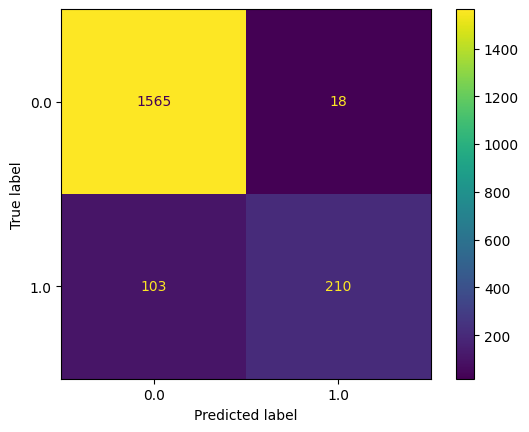

In [22]:
'''
SVM Analysis
'''
print('Grid search found best gamma:', svm_model.best_estimator_.get_params()['svm__gamma'])
print('Grid search found best penalty:', svm_model.best_estimator_.get_params()['svm__kernel'])
print('Grid search found best hyperparameter C:', svm_model.best_estimator_.get_params()['svm__C'])
print("The following is only important if using poly or sigmoid kernel:")
print('Grid search found best coef0:', svm_model.best_estimator_.get_params()['svm__coef0'])
print()

# feature weights
feats = svm_model.best_estimator_.named_steps['onehot'].get_feature_names_out()
print("Feature weights")
for i, coef in enumerate(logreg_model.best_estimator_.named_steps['lr'].coef_[0]): 
    print(f"{feats[i] + ':':31s} {coef}")
print()

# analysis
analyze_model(svm_model, X_test, X_train, y_test, y_train)